### Clasificación de imágenes utilizando una CNN(Red Neuronal Convolucional)

### Módulos utilizados

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.utils import to_categorical
import time
from sklearn.metrics import f1_score

##cargar el dataset CIFAR-10

In [ ]:
dataset = keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = dataset.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 250s 1us/step


## Normalizar los valores de píxeles a rango [0,1]

In [ ]:
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

In [ ]:
print("Tamaño de entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño de prueba:", X_test.shape, y_test.shape)

Tamaño de entrenamiento: (50000, 32, 32, 3) (50000, 1)
Tamaño de prueba: (10000, 32, 32, 3) (10000, 1)


## Mostrar algunas imágenes

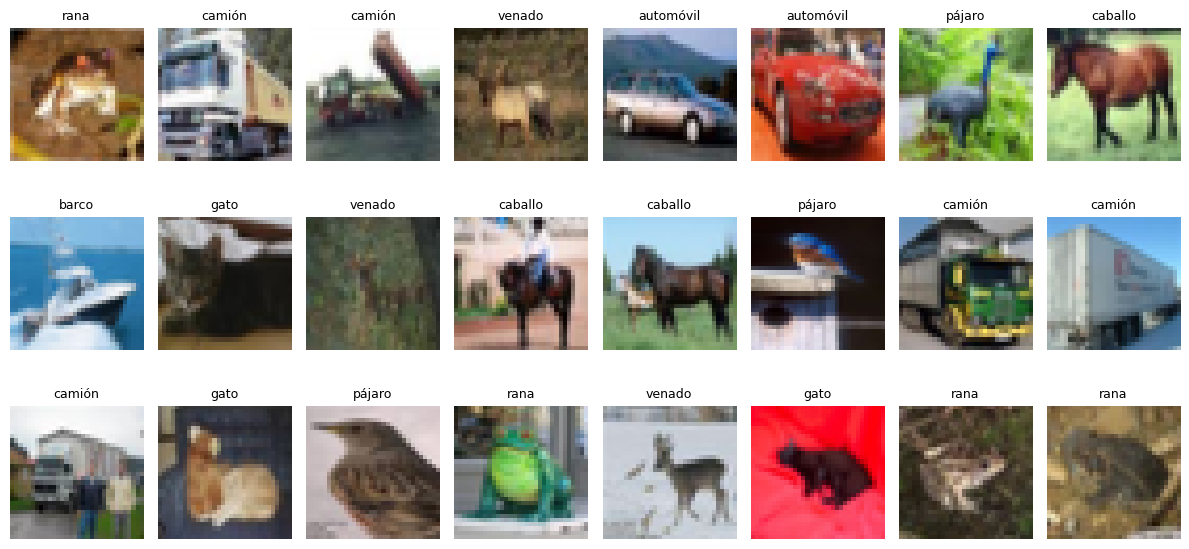

In [ ]:
# Definir nombres de clases
class_names = ['avión', 'automóvil', 'pájaro',  'gato',  'venado',
               'perro', 'rana',      'caballo', 'barco', 'camión']

# Mostrar 24 imágenes
plt.figure(figsize=(12,6))
for i in range(24):
    plt.subplot(3, 8, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[int(y_train[i][0])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

### one-hot encoding

In [ ]:

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#imprimo los 10 primeros targets
for i in range(10):
  etiqueta = np.argmax(y_train[i])
  print(f"y_train[{i}]]: {y_train[i]} -> etiqueta: {etiqueta}")

y_train[0]]: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] -> etiqueta: 6
y_train[1]]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] -> etiqueta: 9
y_train[2]]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] -> etiqueta: 9
y_train[3]]: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> etiqueta: 4
y_train[4]]: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -> etiqueta: 1
y_train[5]]: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -> etiqueta: 1
y_train[6]]: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] -> etiqueta: 2
y_train[7]]: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> etiqueta: 7
y_train[8]]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] -> etiqueta: 8
y_train[9]]: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] -> etiqueta: 3


## Modelo CNN con 4 capas convolucionales, pooling y fully connected regularización L2

### Definición del Modelo

In [ ]:
l2_value = 1e-4  # Regularización L2 moderada

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same',
                  kernel_regularizer=regularizers.l2(l2_value)),                        # Capa convolucional 1
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_value)),                        # Capa convolucional 2
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_value)),                        # Capa convolucional 2
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_value)),                        # Capa convolucional 3
    layers.Flatten(),                                                                   # Aplanar antes de fully connected
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_value)), # Capa fully connected (densa)
    layers.Dense(10, activation='softmax')                                              # Capa de salida con softmax (10 clases)
])

# Mostrar el resumen del modelo
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,439,818 (5.49 MB)

 Trainable params: 1,439,818 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

### Definir aumentos de datos y Ajustar generador a los datos

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotación aleatoria de la imagen (±15°)
    width_shift_range=0.1,    # Desplazamiento horizontal aleatorio (10%)
    height_shift_range=0.1,   # Desplazamiento vertical aleatorio (10%)
    horizontal_flip=True,     # Volteo horizontal aleatorio
    zoom_range=0.1            # Zoom aleatorio (±10%)
)

datagen.fit(X_train)

### Compilar el modelo

In [ ]:
from tensorflow.keras import optimizers

# Definir un Adam con otro learning rate
opt = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entrenar el modelo y agregamos EarlyStopping

In [ ]:
#Callback de EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_loss', # monitoreamos la pérdida en al validación
    patience = 8,         # establecemos cuantas épocas van a pasar sin mejorar el modelo antes de parar
    restore_best_weights = True # retornamos los mejores pesos
)

# --- Medir tiempo de entrenamiento ---
start_time = time.time()

history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    epochs=80,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

training_time = time.time() - start_time

Epoch 1/80


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 148s 372ms/step - accuracy: 0.2936 - loss: 1.9461 - val_accuracy: 0.5162 - val_loss: 1.3793
Epoch 2/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 137s 350ms/step - accuracy: 0.5126 - loss: 1.4067 - val_accuracy: 0.5702 - val_loss: 1.2602
Epoch 3/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 136s 347ms/step - accuracy: 0.5862 - loss: 1.2132 - val_accuracy: 0.6425 - val_loss: 1.0838
Epoch 4/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.6181 - loss: 1.1340 - val_accuracy: 0.6586 - val_loss: 1.0456
Epoch 5/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.6605 - loss: 1.0471 - val_accuracy: 0.6920 - val_loss: 0.9587
Epoch 6/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 141s 361ms/step - accuracy: 0.6829 - loss: 0.9840 - val_accuracy: 0.7037 - val_loss: 0.9456
Epoch 7/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.6996 - loss: 0.9415 - val_accuracy: 0.7106 - val_loss: 0.9264
Epoch 8/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.7134 - loss: 0.91

In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"En el Test --> Exactitud : {train_acc:.4f}, Loss: {train_loss}")

1563/1563 - 33s - 21ms/step - accuracy: 0.8333 - loss: 0.6167
En el Test --> Exactitud : 0.8333, Loss: 0.6167009472846985


### Evaluación del modelo

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"En el Test --> Exactitud : {test_acc:.4f}, Loss: {test_loss}")

313/313 - 7s - 22ms/step - accuracy: 0.7933 - loss: 0.7359
En el Test --> Exactitud : 0.7933, Loss: 0.7358981966972351


### Graficar curva de loss y accuracy

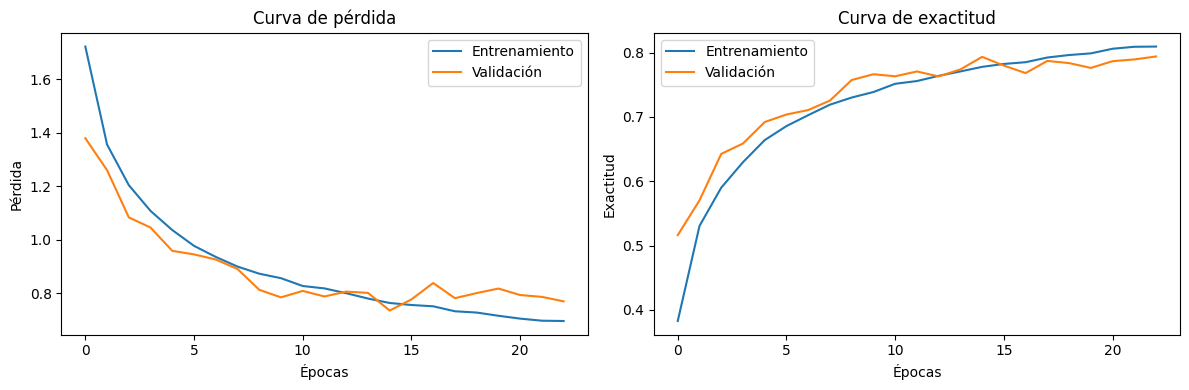

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ---- Loss ----
axes[0].plot(history.history['loss'], label='Entrenamiento')
axes[0].plot(history.history['val_loss'], label='Validación')
axes[0].set_title("Curva de pérdida")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].legend()

# ---- Accuracy ----
axes[1].plot(history.history['accuracy'], label='Entrenamiento')
axes[1].plot(history.history['val_accuracy'], label='Validación')
axes[1].set_title("Curva de exactitud")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Exactitud")
axes[1].legend()

plt.tight_layout()
plt.show()

### Matriz de Confusión

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


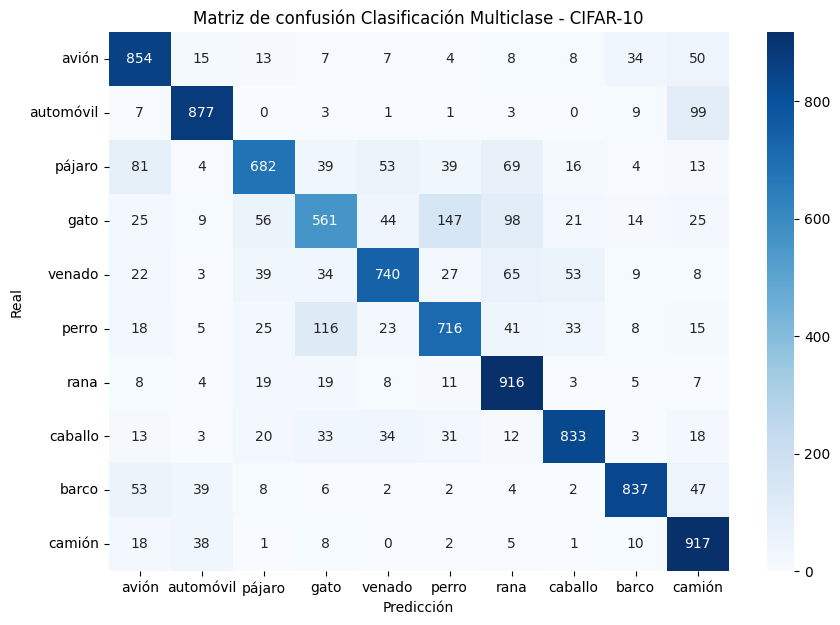

In [ ]:
# Predicciones: obtener la salida de probabilidades en formato one-hot
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) # obtener el valor correspondiente de la clase cuya probabilidad es la mayor

# convertir etiqueta de one-hot a valor correspondiente entero)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizar la Matriz
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión Clasificación Multiclase - CIFAR-10")
plt.show()

### Classification Report

In [ ]:

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       avión       0.78      0.85      0.81      1000
   automóvil       0.88      0.88      0.88      1000
      pájaro       0.79      0.68      0.73      1000
        gato       0.68      0.56      0.61      1000
      venado       0.81      0.74      0.77      1000
       perro       0.73      0.72      0.72      1000
        rana       0.75      0.92      0.82      1000
     caballo       0.86      0.83      0.85      1000
       barco       0.90      0.84      0.87      1000
      camión       0.76      0.92      0.83      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

# F1-score promedio (macro)
f1 = f1_score(y_true, y_pred_classes, average='macro')

# Número total de parámetros entrenables
params = model.count_params()

# Número de épocas realmente entrenadas
epochs_used = len(history.history['loss'])


# Crear DataFrame con una sola fila resumen
summary = pd.DataFrame([{
    "accuracy": test_acc,
    "F1_macro": f1,
    "loss": test_loss,
    "epochs": epochs_used,
    "params": params,
    "training_time_sec": training_time
}])

# Guardar en CSV
summary.to_csv("01_CNN_clasificacion.csv", index=False)

print("\n Archivo 'summary.csv' creado con las métricas principales.")




 Archivo 'summary.csv' creado con las métricas principales.
